In [26]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline



In [15]:
def detection(image):
    image_edges = _edges_detection(image, 200, 250)
    
    # Close gaps between edges (double page clouse => rectangle kernel)
    closed_edges = cv2.morphologyEx(image_edges, 
                                    cv2.MORPH_CLOSE, 
                                    np.ones((5, 11)))
    # Countours
    page_contour = _find_page_contours(closed_edges, resize(image))
    # Recalculate to original scale
    page_contour = page_contour.dot(ratio(image))    
    # Transform prespective
    new_image = _persp_transform(image, page_contour)
    return new_image
   

def _edges_detection(img, minVal, maxVal):
    """Preprocessing (gray, thresh, filter, border) + Canny edge detection."""
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)

    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 115, 4)

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5,
                             cv2.BORDER_CONSTANT,
                             value=[0, 0, 0])
    return cv2.Canny(img, minVal, maxVal)


def _four_corners_sort(pts):
    """Sort corners in order: top-left, bot-left, bot-right, top-right."""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def _contour_offset(cnt, offset):
    """Offset contour because of 5px border."""
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def _find_page_contours(edges, img):
    """Finding corner points of page contour."""
    
    contours, hierarchy = cv2.findContours(edges,
                                                cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                             [0, height-5],
                             [width-5, height-5],
                             [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = _four_corners_sort(page_contour)
    return _contour_offset(page_contour, (-5, -5))


def _persp_transform(img, s_points):
    """Transform perspective from start points to target points."""
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))

In [16]:
SMALL_HEIGHT = 800


def implt(img, cmp=None, t=''):
    
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()


def resize(img, height=SMALL_HEIGHT, allways=False):
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height=SMALL_HEIGHT):
    return img.shape[0] / height


def img_extend(img, shape):
    x = np.zeros(shape, np.uint8)
    x[:img.shape[0], :img.shape[1]] = img
    return x

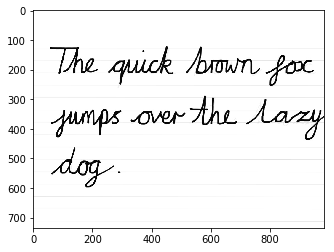

In [39]:
# Loading image (converting to RGB)
image = cv2.cvtColor(cv2.imread("C://Users/Ayush Singh/Documents/Jupyter Notebook files/OCR/Images/img3.jpg"), cv2.COLOR_BGR2RGB)
image = detection(image)
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
implt(img, 'gray')

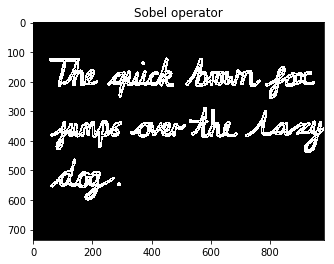

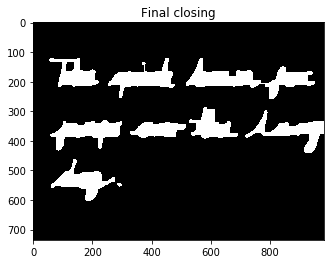

In [40]:
def sobel(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def edge_detect(im):
    return np.max(np.array([sobel(im[:,:, 0]), sobel(im[:,:, 1]), sobel(im[:,:, 2]) ]), axis=0)

# Image pre-processing - blur, edges, threshold, closing
blurred = cv2.GaussianBlur(image, (5, 5), 18)
edges = edge_detect(blurred)
ret, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((20,20), np.uint8))

implt(edges, 'gray', 'Sobel operator')
implt(bw_image, 'gray', 'Final closing')

In [41]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def intersect(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0:
        return False
    return True

def group_rectangles(rec):
    """
    Uion intersecting rectangles
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
            
    return final

In [47]:
def text_detect(img, original):
    small = resize(img, 2000)
    image = resize(original, 2000)
    
    mask = np.zeros(small.shape, np.uint8)
    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    implt(img, 'gray')
    index = 0    
    boxes = []
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        r = cv2.countNonZero(maskROI) / (w * h)
        
        if r > 0.1 and 2000 > w > 10 and 1600 > h > 10 and h/w < 3 and w/h < 10:
            boxes += [[x, y, w, h]]
        index = hierarchy[0][index][0]
        
    boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y),(x+w,y+h), (255, 25, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x+w, y+h])))

    implt(image, t='Bounding rectangles')

    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    return boxes[1:]  

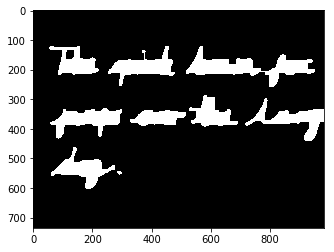

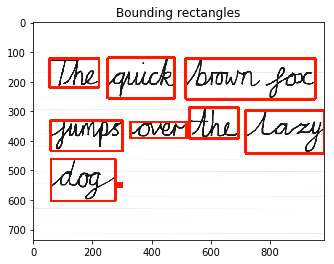

Number of boxes: 9


In [48]:
# Get text bounding boxes
boxes = text_detect(bw_image, image)
print("Number of boxes:", len(boxes))

In [44]:
for i in boxes:
    print(i)

[285 542 299 555]
[ 60 461 277 603]
[328 337 518 391]
[ 59 331 302 434]
[717 298 982 442]
[527 287 692 393]
[515 122 952 260]
[ 55 122 222 220]
[252 120 478 257]
